In [1]:
%run ./Definitions.ipynb
!nvidia-smi
import os

2019-12-19 20:49:41.688279
thunder  Thu Dec 19 20:49:41 2019
[0] GeForce GTX 1080 Ti | 40'C,   0 % |    10 / 11178 MB |
[1] GeForce GTX 1080 Ti | 25'C,   0 % |    10 / 11178 MB |
[2] GeForce GTX 1080 Ti | 26'C,   0 % | 10895 / 11178 MB | anthoula(10885M)
[3] GeForce GTX 1080 Ti | 25'C,   0 % |    10 / 11178 MB |
[4] GeForce GTX 1080 Ti | 23'C,   0 % |   213 / 11178 MB | srikanth(203M)
[5] GeForce GTX 1080 Ti | 26'C,   0 % | 10799 / 11178 MB | gerritsn(10789M)
[6] GeForce GTX 1080 Ti | 30'C,   0 % |    10 / 11178 MB |
[7] GeForce GTX 1080 Ti | 28'C,   0 % |    10 / 11178 MB |


/ds/environments/python2020/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
/ds/environments/python2020/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Dataset consist of 85730 patients data with 6251 features for each patient
Function definitions executed
Definitions DONE !!

Thu Dec 19 20:49:54 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 29%   40C    P0    59W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 29%   25C    P8     7W / 250W |     10Mi

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "0"   # choose here your GPU (0-7)

import tensorflow as tf
import tensorflow.compat.v1 as tf
import keras
import tensorflow.python.keras.backend as K


In [3]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

### LOAD valid train test and validation image names 

In [4]:
valid_traindf_names = pd.read_pickle(funduspath_CR + 'valid_traindf_names.pkl')
valid_valdf_names = pd.read_pickle(funduspath_CR + 'valid_valdf_names.pkl')
valid_testdf_names = pd.read_pickle(funduspath_CR + 'valid_testdf_names.pkl')

valid_traindf_names.shape , valid_valdf_names.shape , valid_testdf_names.shape

((101834, 5), (33943, 5), (33936, 5))

In [5]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

## Handling Imbalanced Data sets

In [6]:
which_gt = 4 # CHANGE 1,2,3,4 implies 'GT523', 'GT19', 'GTi', 'GTu'
n_NG = 0 # non glaucoma
n_G = 0  # glaucoma

GT_dict = {1:'GT523',2:'GT19',3:'GTi',4:'GTu'}
Class = GT_dict[which_gt]
temp = valid_traindf_names[Class]
for i in range(len(temp)):
    if(temp[i] == '1'):
        n_G += 1
    else:
        n_NG += 1
        
print("No. of Glaucoma patients in training set:",n_G)
print("No. of non-Glaucoma patients in training set:",n_NG)

No. of Glaucoma patients in training set: 2379
No. of non-Glaucoma patients in training set: 99455


### 1. Over Sampling Train set

In [7]:
# Oversample the minority class

X_train = valid_traindf_names['Fundus_Filenames']
y_train = valid_traindf_names[GT_dict[which_gt]]

# Converting class values to int 1 or 0
y_train = y_train.astype(int)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_glaucoma = X[X[Class]==0]
glaucoma = X[X[Class]==1]

# upsample minority
glaucoma_upsampled = resample(glaucoma,
                              replace=True, # sample with replacement
                              n_samples=len(not_glaucoma), # match number in majority class
                              random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_glaucoma,glaucoma_upsampled])

# shuffle upsampled dataframe for training
upsampled = upsampled.sample(frac=1)


In [8]:
X[Class].value_counts()

0    99455
1     2379
Name: GTu, dtype: int64

In [9]:
upsampled[Class].value_counts()

1    99455
0    99455
Name: GTu, dtype: int64

#### validation distribution

In [10]:
valid_valdf_names[Class].value_counts()

0    33134
1      809
Name: GTu, dtype: int64

### Oversampling minority with less imbalance - in train set
Original imbalance ratio **X-** 1:40

Imbalance ratio **up1**-1:5, **up2**-1:10, **up3**-1:20, **up4**-1:30

Balanced ratio **upsampled**-1:1

In [11]:
# upsampling minority
glaucoma_up1 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/5), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up2 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/10), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up3 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/20), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up4 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/30), # match number in majority class
                        random_state=42) # reproducible results

# combine majority and upsampled minority
up1 = pd.concat([not_glaucoma,glaucoma_up1])
up2 = pd.concat([not_glaucoma,glaucoma_up2])
up3 = pd.concat([not_glaucoma,glaucoma_up3])
up4 = pd.concat([not_glaucoma,glaucoma_up4])

# shuffle upsampled dataframe for training
up1 = up1.sample(frac=1)
up2 = up2.sample(frac=1)
up3 = up3.sample(frac=1)
up4 = up4.sample(frac=1)


In [12]:
print("up1")
print(up1[Class].value_counts())
print("up2")
print(up2[Class].value_counts())
print("up1")
print(up3[Class].value_counts())
print("up4")
print(up4[Class].value_counts())

up1
0    99455
1    19891
Name: GTu, dtype: int64
up2
0    99455
1     9945
Name: GTu, dtype: int64
up1
0    99455
1     4972
Name: GTu, dtype: int64
up4
0    99455
1     3315
Name: GTu, dtype: int64


### 2. Class weight

In [13]:
# Setting class weight for retraining:

# compute_class_weight('balanced', np.unique(y_train), y_train)
# class_weight = [0.5, 2] # experiment with different values
# n_NG , n_G

## Define Model and Metrics

In [14]:
reg_value=0.001
METRICS = [keras.metrics.BinaryAccuracy(name='Accuracy'),
           Precision, 
           Recall, 
           F1,
           keras.metrics.AUC(name='AUC')]

def mobilenet_model():       
    mobile_conv = MobileNet(weights='imagenet', include_top=False, input_shape=(red_size, red_size, 3))

    # UnFreeze last conv layer
    for layer in mobile_conv.layers[:78]:
        layer.trainable = False
    for layer in mobile_conv.layers[78:]:
        layer.trainable = True
        
    # Create the model
    model = models.Sequential()
    model.add(mobile_conv)
 
    # Add new layers
    # https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1, activation='sigmoid'))
 
    return model

### Augmentation
https://nbviewer.jupyter.org/github/aleju/imgaug-doc/blob/master/notebooks/A01%20-%20Load%20and%20Augment%20an%20Image.ipynb

In [15]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(scale=1.1),
    iaa.Affine(rotate=(-10, 10)),
    # iaa.GammaContrast(0.9),
    iaa.Resize({"height": 230, "width": 230}),
    iaa.CropToFixedSize(width=red_size, height=red_size)
    ])

### Flow from Dataframe
https://www.kaggle.com/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe

In [16]:
# To use same settings as mobilenet
# from keras.applications.mobilenet import preprocess_input
# train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function=seq.augment_image, samplewise_center=True, rescale= 1./255) 
val_datagen = ImageDataGenerator(samplewise_center=True, rescale=1./255)  
BATCH_SIZE = 32

print("\nOriginal imbalanced train data: ")
imb_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = valid_traindf_names, # imbalanced train dataframe
    directory=trainpath,
    x_col=valid_traindf_names.columns[0],
    y_col=valid_traindf_names.columns[which_gt],
#     x_col = upsampled.columns[0], # upsampled data
#     y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    shuffle=False,
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nOriginal validation data: ")
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=valid_valdf_names,
    directory=valpath,
    x_col=valid_valdf_names.columns[0],
    y_col=valid_valdf_names.columns[which_gt],
    class_mode="raw",
    shuffle=False,
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUpsampled train data 1:1 ")
up_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = upsampled, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = upsampled.columns[0], # upsampled data
    y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    shuffle=False,
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP1 train data 1:5 ")
up1_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up1, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up1.columns[0], # upsampled data
    y_col = up1.columns[1], # upsampled data
    class_mode="raw",
    shuffle=False,
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP2 train data 1:10 ")
up2_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up2, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up2.columns[0], # upsampled data
    y_col = up2.columns[1], # upsampled data
    class_mode="raw",
    shuffle=False,
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP3 train data 1:20 ")
up3_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up3, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up3.columns[0], # upsampled data
    y_col = up3.columns[1], # upsampled data
    class_mode="raw",
    shuffle=False,
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP4 train data 1:30 ")
up4_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up4, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up4.columns[0], # upsampled data
    y_col = up4.columns[1], # upsampled data
    class_mode="raw",
    shuffle=False,
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)



Original imbalanced train data: 
Found 101834 validated image filenames.

Original validation data: 
Found 33943 validated image filenames.

Upsampled train data 1:1 
Found 198910 validated image filenames.

UP1 train data 1:5 
Found 119346 validated image filenames.

UP2 train data 1:10 
Found 109400 validated image filenames.

UP3 train data 1:20 
Found 104427 validated image filenames.

UP4 train data 1:30 
Found 102770 validated image filenames.


### Choosing parameters and model compile

In [17]:
which_model = mobilenet_model
# which_model = vgg_model
# which_model = resnet50_model

model = which_model()
learning_rate  = 0.0001 
decay = 1e-5
momentum=0.9
opt = Adam(lr=learning_rate, decay = decay) 
model.compile(loss='binary_crossentropy', metrics=METRICS, optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 1,589,249
Non-trainable params: 1,640,640
_________________________________________________________________


In [18]:
reduce_lr = ReduceLROnPlateau(monitor='val_F1', factor=0.1, patience=10, min_lr=0.000001, verbose=1)
n_epochs=200
n_steps_per_epoch = 50
n_validation_steps = 10

### Train with upsampled data (1:1)

In [19]:
start = time.time()
up_history = model.fit_generator(up_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              callbacks=[reduce_lr]
                             )
end = time.time()

/ds/environments/python2020/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):


Epoch 1/200
50/50 [==============================] - 23s 461ms/step - loss: 0.7277 - Accuracy: 0.5462 - Precision: 0.5368 - Recall: 0.5208 - F1: 0.5201 - AUC: 0.5779 - val_loss: 1.0336 - val_Accuracy: 0.4000 - val_Precision: 0.0524 - val_Recall: 0.6500 - val_F1: 0.0955 - val_AUC: 0.7024
Epoch 2/200
50/50 [==============================] - 22s 436ms/step - loss: 0.6733 - Accuracy: 0.6050 - Precision: 0.6015 - Recall: 0.6181 - F1: 0.6014 - AUC: 0.6539 - val_loss: 0.8964 - val_Accuracy: 0.3313 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.0266
Epoch 3/200
50/50 [==============================] - 23s 470ms/step - loss: 0.6518 - Accuracy: 0.6306 - Precision: 0.6429 - Recall: 0.6554 - F1: 0.6384 - AUC: 0.6832 - val_loss: 1.2614 - val_Accuracy: 0.0781 - val_Precision: 0.0230 - val_Recall: 0.5000 - val_F1: 0.0435 - val_AUC: 0.7042
Epoch 4/200
50/50 [==============================] - 24s 476ms/step - loss: 0.6662 - Accuracy: 0.6181 - Precision: 0.6273 - 

Epoch 29/200
50/50 [==============================] - 23s 456ms/step - loss: 0.5646 - Accuracy: 0.7059 - Precision: 0.7070 - Recall: 0.7265 - F1: 0.7089 - AUC: 0.7771 - val_loss: 0.6257 - val_Accuracy: 0.4281 - val_Precision: 0.0186 - val_Recall: 0.2500 - val_F1: 0.0344 - val_AUC: 0.6213
Epoch 30/200
50/50 [==============================] - 23s 462ms/step - loss: 0.5406 - Accuracy: 0.7250 - Precision: 0.7165 - Recall: 0.7604 - F1: 0.7318 - AUC: 0.8037 - val_loss: 0.6833 - val_Accuracy: 0.5656 - val_Precision: 0.0352 - val_Recall: 0.3000 - val_F1: 0.0625 - val_AUC: 0.7444
Epoch 31/200
50/50 [==============================] - 23s 455ms/step - loss: 0.5724 - Accuracy: 0.7031 - Precision: 0.6864 - Recall: 0.7261 - F1: 0.6981 - AUC: 0.7716 - val_loss: 0.7124 - val_Accuracy: 0.4469 - val_Precision: 0.0238 - val_Recall: 0.4000 - val_F1: 0.0449 - val_AUC: 0.6632
Epoch 32/200
50/50 [==============================] - 22s 442ms/step - loss: 0.5499 - Accuracy: 0.7163 - Precision: 0.7029 - Recall: 

50/50 [==============================] - 23s 468ms/step - loss: 0.5455 - Accuracy: 0.7356 - Precision: 0.7356 - Recall: 0.7602 - F1: 0.7411 - AUC: 0.8016 - val_loss: 0.7201 - val_Accuracy: 0.4688 - val_Precision: 0.0170 - val_Recall: 0.2000 - val_F1: 0.0311 - val_AUC: 0.7848
Epoch 58/200
50/50 [==============================] - 23s 456ms/step - loss: 0.5512 - Accuracy: 0.7275 - Precision: 0.7098 - Recall: 0.7486 - F1: 0.7224 - AUC: 0.7933 - val_loss: 0.7349 - val_Accuracy: 0.4625 - val_Precision: 0.0446 - val_Recall: 0.5000 - val_F1: 0.0812 - val_AUC: 0.5727
Epoch 59/200
50/50 [==============================] - 23s 455ms/step - loss: 0.5567 - Accuracy: 0.7106 - Precision: 0.7092 - Recall: 0.7294 - F1: 0.7146 - AUC: 0.7892 - val_loss: 0.7055 - val_Accuracy: 0.5281 - val_Precision: 0.0339 - val_Recall: 0.4000 - val_F1: 0.0621 - val_AUC: 0.6739
Epoch 60/200
50/50 [==============================] - 24s 471ms/step - loss: 0.5629 - Accuracy: 0.7056 - Precision: 0.7283 - Recall: 0.7165 - F1: 

50/50 [==============================] - 22s 445ms/step - loss: 0.5661 - Accuracy: 0.7081 - Precision: 0.7171 - Recall: 0.7191 - F1: 0.7096 - AUC: 0.7760 - val_loss: 0.7227 - val_Accuracy: 0.5063 - val_Precision: 0.0567 - val_Recall: 0.4000 - val_F1: 0.0979 - val_AUC: 0.6620
Epoch 86/200
50/50 [==============================] - 24s 472ms/step - loss: 0.5665 - Accuracy: 0.7000 - Precision: 0.6848 - Recall: 0.7159 - F1: 0.6943 - AUC: 0.7756 - val_loss: 0.6381 - val_Accuracy: 0.5906 - val_Precision: 0.0167 - val_Recall: 0.0667 - val_F1: 0.0267 - val_AUC: 0.4541
Epoch 87/200
50/50 [==============================] - 23s 451ms/step - loss: 0.5540 - Accuracy: 0.7319 - Precision: 0.7236 - Recall: 0.7475 - F1: 0.7289 - AUC: 0.7931 - val_loss: 0.6573 - val_Accuracy: 0.5781 - val_Precision: 0.0563 - val_Recall: 0.5167 - val_F1: 0.0998 - val_AUC: 0.6373
Epoch 88/200
50/50 [==============================] - 23s 452ms/step - loss: 0.5430 - Accuracy: 0.7319 - Precision: 0.7200 - Recall: 0.7580 - F1: 

50/50 [==============================] - 23s 451ms/step - loss: 0.5588 - Accuracy: 0.7163 - Precision: 0.7146 - Recall: 0.7394 - F1: 0.7214 - AUC: 0.7836 - val_loss: 0.8135 - val_Accuracy: 0.4688 - val_Precision: 0.0292 - val_Recall: 0.4500 - val_F1: 0.0544 - val_AUC: 0.5840
Epoch 114/200
50/50 [==============================] - 23s 451ms/step - loss: 0.5583 - Accuracy: 0.7100 - Precision: 0.6797 - Recall: 0.7512 - F1: 0.7082 - AUC: 0.7860 - val_loss: 0.8502 - val_Accuracy: 0.4688 - val_Precision: 0.0114 - val_Recall: 0.2000 - val_F1: 0.0216 - val_AUC: 0.8090
Epoch 115/200
50/50 [==============================] - 23s 462ms/step - loss: 0.5719 - Accuracy: 0.6981 - Precision: 0.6869 - Recall: 0.7219 - F1: 0.6976 - AUC: 0.7715 - val_loss: 0.7095 - val_Accuracy: 0.4500 - val_Precision: 0.0392 - val_Recall: 0.4500 - val_F1: 0.0714 - val_AUC: 0.6310
Epoch 116/200
50/50 [==============================] - 23s 455ms/step - loss: 0.5682 - Accuracy: 0.7075 - Precision: 0.7202 - Recall: 0.7110 - F

50/50 [==============================] - 21s 426ms/step - loss: 0.5456 - Accuracy: 0.7250 - Precision: 0.7142 - Recall: 0.7568 - F1: 0.7290 - AUC: 0.7987 - val_loss: 0.7976 - val_Accuracy: 0.4187 - val_Precision: 0.0159 - val_Recall: 0.3000 - val_F1: 0.0301 - val_AUC: 0.5732
Epoch 142/200
50/50 [==============================] - 22s 437ms/step - loss: 0.5653 - Accuracy: 0.7019 - Precision: 0.6978 - Recall: 0.7244 - F1: 0.7042 - AUC: 0.7783 - val_loss: 0.8271 - val_Accuracy: 0.3844 - val_Precision: 0.0262 - val_Recall: 0.3500 - val_F1: 0.0483 - val_AUC: 0.5823
Epoch 143/200
50/50 [==============================] - 21s 424ms/step - loss: 0.5368 - Accuracy: 0.7337 - Precision: 0.7193 - Recall: 0.7636 - F1: 0.7351 - AUC: 0.8108 - val_loss: 0.8623 - val_Accuracy: 0.4187 - val_Precision: 0.0131 - val_Recall: 0.1500 - val_F1: 0.0241 - val_AUC: 0.4727
Epoch 144/200
50/50 [==============================] - 22s 446ms/step - loss: 0.5437 - Accuracy: 0.7275 - Precision: 0.7258 - Recall: 0.7508 - F

50/50 [==============================] - 23s 469ms/step - loss: 0.5602 - Accuracy: 0.7156 - Precision: 0.7133 - Recall: 0.7463 - F1: 0.7215 - AUC: 0.7832 - val_loss: 0.7301 - val_Accuracy: 0.5500 - val_Precision: 0.0321 - val_Recall: 0.4500 - val_F1: 0.0595 - val_AUC: 0.7251
Epoch 170/200
50/50 [==============================] - 22s 442ms/step - loss: 0.5426 - Accuracy: 0.7462 - Precision: 0.7460 - Recall: 0.7746 - F1: 0.7544 - AUC: 0.8046 - val_loss: 0.6701 - val_Accuracy: 0.5531 - val_Precision: 0.0606 - val_Recall: 0.6000 - val_F1: 0.1070 - val_AUC: 0.6912
Epoch 171/200
50/50 [==============================] - 22s 437ms/step - loss: 0.5543 - Accuracy: 0.7075 - Precision: 0.6882 - Recall: 0.7531 - F1: 0.7136 - AUC: 0.7895 - val_loss: 0.6889 - val_Accuracy: 0.4969 - val_Precision: 0.0389 - val_Recall: 0.4000 - val_F1: 0.0697 - val_AUC: 0.5865
Epoch 172/200
50/50 [==============================] - 23s 461ms/step - loss: 0.5602 - Accuracy: 0.7044 - Precision: 0.6885 - Recall: 0.7447 - F

50/50 [==============================] - 21s 422ms/step - loss: 0.5510 - Accuracy: 0.7175 - Precision: 0.6975 - Recall: 0.7436 - F1: 0.7142 - AUC: 0.7913 - val_loss: 0.7365 - val_Accuracy: 0.5312 - val_Precision: 0.0063 - val_Recall: 0.1000 - val_F1: 0.0118 - val_AUC: 0.5022
Epoch 198/200
50/50 [==============================] - 21s 410ms/step - loss: 0.5566 - Accuracy: 0.7188 - Precision: 0.7023 - Recall: 0.7382 - F1: 0.7129 - AUC: 0.7874 - val_loss: 0.7447 - val_Accuracy: 0.5406 - val_Precision: 0.0243 - val_Recall: 0.2167 - val_F1: 0.0427 - val_AUC: 0.4624
Epoch 199/200
50/50 [==============================] - 22s 439ms/step - loss: 0.5557 - Accuracy: 0.7019 - Precision: 0.6959 - Recall: 0.7175 - F1: 0.6983 - AUC: 0.7861 - val_loss: 0.6675 - val_Accuracy: 0.5031 - val_Precision: 0.0618 - val_Recall: 0.5583 - val_F1: 0.1072 - val_AUC: 0.6311
Epoch 200/200
50/50 [==============================] - 21s 428ms/step - loss: 0.5364 - Accuracy: 0.7356 - Precision: 0.7153 - Recall: 0.7690 - F

In [20]:
print("Time taken:",end-start)

Time taken: 4524.189272642136


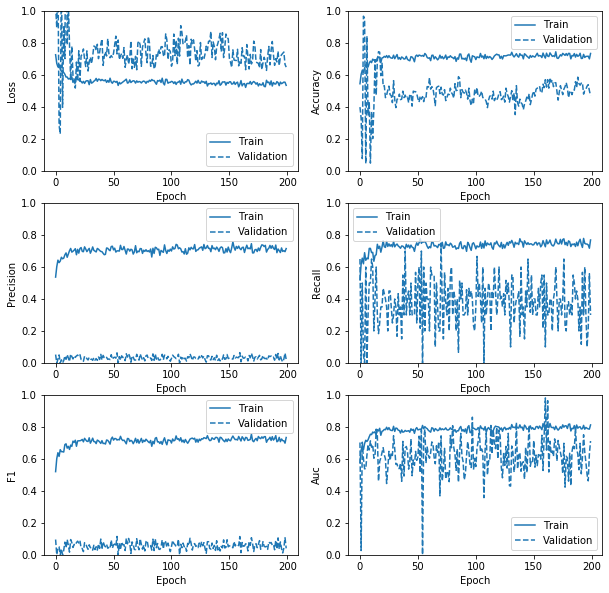

In [21]:
plt.figure(figsize=(10,10))
plot_metrics(up_history)

### Train with UP2 (1:10)

In [22]:
start = time.time()
up2_history = model.fit_generator(up2_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              callbacks=[reduce_lr]
                             )
end = time.time()

Epoch 1/200
50/50 [==============================] - 20s 403ms/step - loss: 0.6860 - Accuracy: 0.5806 - Precision: 0.1652 - Recall: 0.8075 - F1: 0.2625 - AUC: 0.8088 - val_loss: 0.9090 - val_Accuracy: 0.4344 - val_Precision: 0.0480 - val_Recall: 0.5500 - val_F1: 0.0860 - val_AUC: 0.6250
Epoch 2/200
50/50 [==============================] - 20s 402ms/step - loss: 0.6520 - Accuracy: 0.6288 - Precision: 0.1906 - Recall: 0.8055 - F1: 0.2971 - AUC: 0.8065 - val_loss: 0.8143 - val_Accuracy: 0.4062 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.2868
Epoch 3/200
50/50 [==============================] - 18s 365ms/step - loss: 0.6283 - Accuracy: 0.6450 - Precision: 0.1686 - Recall: 0.8028 - F1: 0.2703 - AUC: 0.8051 - val_loss: 0.8178 - val_Accuracy: 0.4500 - val_Precision: 0.0358 - val_Recall: 0.4667 - val_F1: 0.0647 - val_AUC: 0.6572
Epoch 4/200
50/50 [==============================] - 19s 377ms/step - loss: 0.5887 - Accuracy: 0.6875 - Precision: 0.2168 - 

50/50 [==============================] - 18s 370ms/step - loss: 0.3450 - Accuracy: 0.8981 - Precision: 0.3143 - Recall: 0.3070 - F1: 0.2898 - AUC: 0.7995 - val_loss: 0.4931 - val_Accuracy: 0.7219 - val_Precision: 0.0333 - val_Recall: 0.1500 - val_F1: 0.0543 - val_AUC: 0.5679
Epoch 30/200
50/50 [==============================] - 19s 380ms/step - loss: 0.3439 - Accuracy: 0.8844 - Precision: 0.3707 - Recall: 0.2807 - F1: 0.3002 - AUC: 0.8167 - val_loss: 0.5246 - val_Accuracy: 0.8062 - val_Precision: 0.0389 - val_Recall: 0.1500 - val_F1: 0.0614 - val_AUC: 0.7293
Epoch 31/200
50/50 [==============================] - 18s 365ms/step - loss: 0.3335 - Accuracy: 0.8944 - Precision: 0.3107 - Recall: 0.2783 - F1: 0.2626 - AUC: 0.8064 - val_loss: 0.5465 - val_Accuracy: 0.7063 - val_Precision: 0.0268 - val_Recall: 0.3000 - val_F1: 0.0491 - val_AUC: 0.6651
Epoch 32/200
50/50 [==============================] - 19s 372ms/step - loss: 0.3390 - Accuracy: 0.8919 - Precision: 0.2973 - Recall: 0.2241 - F1: 

50/50 [==============================] - 19s 386ms/step - loss: 0.2930 - Accuracy: 0.8981 - Precision: 0.1800 - Recall: 0.0549 - F1: 0.0808 - AUC: 0.8024 - val_loss: 0.3870 - val_Accuracy: 0.9625 - val_Precision: 0.1000 - val_Recall: 0.1000 - val_F1: 0.1000 - val_AUC: 0.7710
Epoch 58/200
50/50 [==============================] - 20s 406ms/step - loss: 0.2788 - Accuracy: 0.9112 - Precision: 0.2033 - Recall: 0.1060 - F1: 0.1270 - AUC: 0.8120 - val_loss: 0.3927 - val_Accuracy: 0.9031 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5352
Epoch 59/200
50/50 [==============================] - 18s 362ms/step - loss: 0.2880 - Accuracy: 0.9081 - Precision: 0.2400 - Recall: 0.0989 - F1: 0.1325 - AUC: 0.7802 - val_loss: 0.4119 - val_Accuracy: 0.9312 - val_Precision: 0.0200 - val_Recall: 0.1000 - val_F1: 0.0333 - val_AUC: 0.6554
Epoch 60/200
50/50 [==============================] - 19s 383ms/step - loss: 0.2822 - Accuracy: 0.9075 - Precision: 0.2300 - Recall: 0

Epoch 85/200
50/50 [==============================] - 19s 384ms/step - loss: 0.2638 - Accuracy: 0.9081 - Precision: 0.1200 - Recall: 0.0352 - F1: 0.0530 - AUC: 0.8014 - val_loss: 0.3700 - val_Accuracy: 0.9563 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6858
Epoch 86/200
50/50 [==============================] - 21s 416ms/step - loss: 0.2642 - Accuracy: 0.9050 - Precision: 0.2000 - Recall: 0.0609 - F1: 0.0900 - AUC: 0.8193 - val_loss: 0.3332 - val_Accuracy: 0.9625 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.3774
Epoch 87/200
50/50 [==============================] - 19s 377ms/step - loss: 0.2759 - Accuracy: 0.9038 - Precision: 0.0600 - Recall: 0.0145 - F1: 0.0230 - AUC: 0.7782 - val_loss: 0.2953 - val_Accuracy: 0.9500 - val_Precision: 0.2000 - val_Recall: 0.0833 - val_F1: 0.1167 - val_AUC: 0.6513
Epoch 88/200
50/50 [==============================] - 19s 381ms/step - loss: 0.2513 - Accuracy: 0.9119 - Prec

50/50 [==============================] - 19s 377ms/step - loss: 0.2775 - Accuracy: 0.8988 - Precision: 0.0400 - Recall: 0.0100 - F1: 0.0160 - AUC: 0.7874 - val_loss: 0.3456 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5723
Epoch 113/200
50/50 [==============================] - 20s 391ms/step - loss: 0.2583 - Accuracy: 0.9094 - Precision: 0.0800 - Recall: 0.0383 - F1: 0.0480 - AUC: 0.8059 - val_loss: 0.2817 - val_Accuracy: 0.9594 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5609
Epoch 114/200
50/50 [==============================] - 20s 395ms/step - loss: 0.2588 - Accuracy: 0.9081 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7874 - val_loss: 0.3050 - val_Accuracy: 0.9844 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7964
Epoch 115/200
50/50 [==============================] - 19s 380ms/step - loss: 0.2711 - Accuracy:

50/50 [==============================] - 20s 399ms/step - loss: 0.2419 - Accuracy: 0.9162 - Precision: 0.0200 - Recall: 0.0050 - F1: 0.0080 - AUC: 0.7981 - val_loss: 0.2195 - val_Accuracy: 0.9844 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6278
Epoch 140/200
50/50 [==============================] - 18s 366ms/step - loss: 0.2508 - Accuracy: 0.9094 - Precision: 0.0600 - Recall: 0.0267 - F1: 0.0367 - AUC: 0.8055 - val_loss: 0.2850 - val_Accuracy: 0.9469 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5139
Epoch 141/200
50/50 [==============================] - 19s 372ms/step - loss: 0.2384 - Accuracy: 0.9200 - Precision: 0.0400 - Recall: 0.0117 - F1: 0.0180 - AUC: 0.8028 - val_loss: 0.2672 - val_Accuracy: 0.9875 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5783
Epoch 142/200
50/50 [==============================] - 20s 406ms/step - loss: 0.2832 - Accuracy: 0.8981 - Pr

50/50 [==============================] - 19s 376ms/step - loss: 0.2278 - Accuracy: 0.9212 - Precision: 0.1200 - Recall: 0.0573 - F1: 0.0733 - AUC: 0.8279 - val_loss: 0.2408 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6316
Epoch 167/200
50/50 [==============================] - 20s 393ms/step - loss: 0.2426 - Accuracy: 0.9146 - Precision: 0.0200 - Recall: 0.0100 - F1: 0.0133 - AUC: 0.8123 - val_loss: 0.2111 - val_Accuracy: 0.9937 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6816
Epoch 168/200
50/50 [==============================] - 19s 375ms/step - loss: 0.2297 - Accuracy: 0.9194 - Precision: 0.0400 - Recall: 0.0133 - F1: 0.0200 - AUC: 0.8348 - val_loss: 0.2585 - val_Accuracy: 0.9625 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6269
Epoch 169/200
50/50 [==============================] - 19s 376ms/step - loss: 0.2656 - Accuracy: 0.9000 - Pr

50/50 [==============================] - 19s 375ms/step - loss: 0.2379 - Accuracy: 0.9169 - Precision: 0.0400 - Recall: 0.0250 - F1: 0.0280 - AUC: 0.8108 - val_loss: 0.2762 - val_Accuracy: 0.9531 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6312
Epoch 194/200
50/50 [==============================] - 19s 384ms/step - loss: 0.2406 - Accuracy: 0.9150 - Precision: 0.1600 - Recall: 0.0512 - F1: 0.0763 - AUC: 0.8359 - val_loss: 0.1781 - val_Accuracy: 0.9875 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7045
Epoch 195/200
50/50 [==============================] - 20s 405ms/step - loss: 0.2530 - Accuracy: 0.9112 - Precision: 0.1200 - Recall: 0.0683 - F1: 0.0804 - AUC: 0.7990 - val_loss: 0.2846 - val_Accuracy: 0.9625 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6703
Epoch 196/200
50/50 [==============================] - 19s 385ms/step - loss: 0.2363 - Accuracy: 0.9181 - Pr

In [23]:
print("Time taken:",end-start)

Time taken: 3858.031821012497


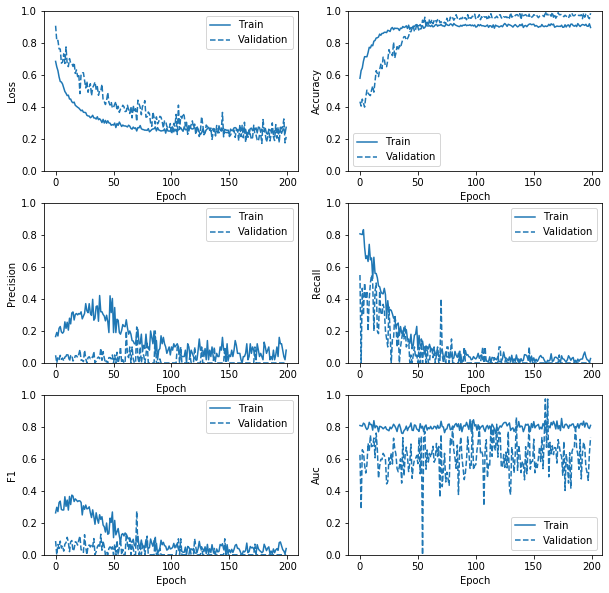

In [24]:
plt.figure(figsize=(10,10))
plot_metrics(up2_history)

### Train with UP3 (1:20)

In [25]:
# start = time.time()
# up3_history = model.fit_generator(up3_train_generator, 
#                               epochs=n_epochs, 
#                               steps_per_epoch=n_steps_per_epoch,
#                               validation_data=validation_generator,
#                               validation_steps=n_validation_steps,
#                               class_weight = [0.5, 1],
#                               callbacks=[reduce_lr]
#                              )
# end = time.time()

In [26]:
# print("Time taken:",end-start)

In [27]:
# plt.figure(figsize=(10,10))
# plot_metrics(up3_history)

### Train with Imbalanced original train data (1:40)

In [28]:
# start = time.time()
# imb_history = model.fit_generator(imb_train_generator,
#                                   epochs=n_epochs,
#                                   steps_per_epoch=n_steps_per_epoch,
#                                   validation_data=validation_generator,
#                                   validation_steps=n_validation_steps,
#                                   class_weight = [0.5, 2],
#                                   callbacks=[reduce_lr]
#                                  )
# end = time.time()

In [29]:
# print("Time taken:",end-start)

In [30]:
# plt.figure(figsize=(10,10))
# plot_metrics(imb_history)

## Evaluation

In [31]:
results_tr = model.evaluate(imb_train_generator,steps=100)
results_vl = model.evaluate(validation_generator,steps=100)

100/100 [==============================] - 18s 178ms/step


In [32]:
print("NAME :\tTRAIN :\tVALIDATION ")
for name, value_tr, value_vl in zip(model.metrics_names, results_tr, results_vl):
    print("%s : %5.3f : %7.3f" %(name, value_tr , value_vl))

# without classweights:
# NAME :	TRAIN :	VALIDATION 
# loss : 0.754 :   0.465
# Accuracy : 0.531 :   0.866
# Precision : 0.006 :   0.006
# Recall : 0.070 :   0.040
# F1 : 0.011 :   0.010
# AUC : 0.565 :   0.544

NAME :	TRAIN :	VALIDATION 
loss : 0.249 :   0.304
Accuracy : 0.964 :   0.974
Precision : 0.015 :   0.000
Recall : 0.013 :   0.000
F1 : 0.012 :   0.000
AUC : 0.595 :   0.623


## Prediction
The output of a binary classification is the probability of a sample belonging to a class.

In [33]:
# PREDICTED LABELS
start = time.time()
pred_tr = model.predict(imb_train_generator)
tr_end = time.time()
pred_vl = model.predict(validation_generator)
vl_end = time.time()

tr_end-start , vl_end-tr_end

(1172.809893131256, 174.749085187912)

In [34]:
# np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newtr.npy', pred_tr)
# np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newvl.npy', pred_vl)

In [35]:
# val_class = []
# for i, predicted in enumerate(pred_vl):
#     if predicted[0] > 0.1:
#         #assign i to class 1
#         val_class.append(1)
#     else:
#         #assign i to class 0
#         val_class.append(0)

In [36]:
# TRUE LABELS

train_labels = valid_traindf_names[Class].tolist()
train_labels = [int(i) for i in train_labels]

val_labels = valid_valdf_names[Class].tolist()
val_labels = [int(i) for i in val_labels]


### ROC Curve

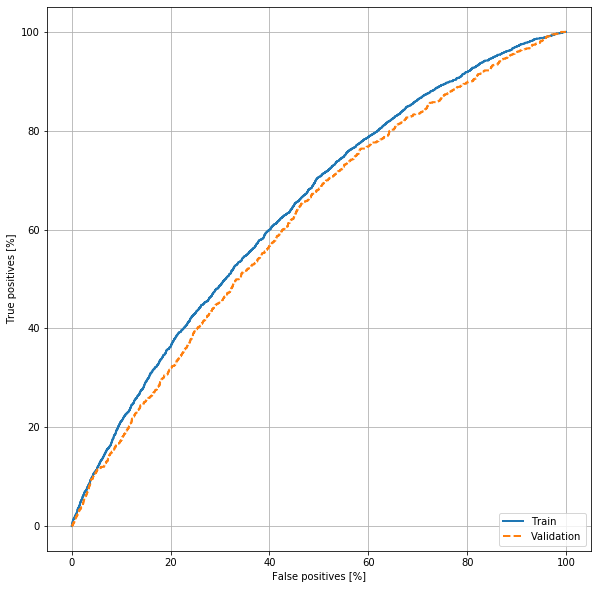

In [37]:
plt.figure(figsize=(10,10))
plot_roc("Train", train_labels, pred_tr, color=colors[0])
plot_roc("Validation", val_labels, pred_vl, color=colors[1],linestyle='--')
# plot_roc("Validation", val_labels, val_class, color=colors[3],linestyle='-.') # theshold 0.1
plt.legend(loc='lower right')

### Confusion matrix

Train data: 
TN: 98225 
FP: 1230 
FN: 2296 
TP: 83
Healthy Patients - correctly identified (True Negatives):  98225 0.9876325976572319
Healthy Patients - predicted to have glaucoma (False Positives):  1230 0.012367402342768086
Glaucoma Patients - predicted healthy (False Negatives):  2296 0.9651113913408995
Glaucoma Patients - correctly identified (True Positives):  83 0.03488860865910046

Total Glaucoma patients:  2379 1.0
Total Healthy patients:  99455 1.0


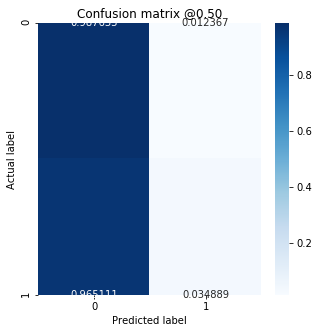

In [38]:
tn, fp, fn, tp = confusion_matrix(train_labels, pred_tr > 0.5).ravel()
train_cm = [tn, fp, fn, tp]
print("Train data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(train_labels, pred_tr)

Validation data: 
TN: 33045 
FP: 89 
FN: 806 
TP: 3
Healthy Patients - correctly identified (True Negatives):  33045 0.997313937345325
Healthy Patients - predicted to have glaucoma (False Positives):  89 0.002686062654674956
Glaucoma Patients - predicted healthy (False Negatives):  806 0.9962917181705809
Glaucoma Patients - correctly identified (True Positives):  3 0.003708281829419036

Total Glaucoma patients:  809 1.0
Total Healthy patients:  33134 1.0


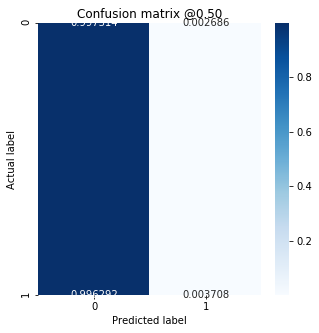

In [39]:
tn, fp, fn, tp = confusion_matrix(val_labels, pred_vl > 0.5).ravel()
val_cm = [tn, fp, fn, tp]
print("Validation data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(val_labels, pred_vl)

### MLFlow 

In [46]:
# history = up2_history
# tag_value = "trained twice bal and 1:10 with 78 tr layers"

# exp_name = get_notebook_name()+"-run at-"+datetime.datetime.now().strftime("%d%b%Y %H:%M")
# keras_model_path = funduspath_CR+ exp_name + '_model'
# save_mlflow(keras_model_path,exp_name,which_gt,which_model,seq,BATCH_SIZE,
#             n_epochs,n_steps_per_epoch,n_validation_steps,
#             reg_value,learning_rate,decay,opt,
#             history,results_tr,results_vl,train_cm,val_cm
#            )

<IPython.core.display.Javascript object>

In [47]:
# client = MlflowClient()
# run = client.create_run('16')
# client.set_tag(run.info.run_id, "tag_key", tag_value)